# NEURAL NETWORK OBJECT RECOGNITION

## PROJECT

UoEO Machine Learning

Assignment Due Date: 20 January, 2025

## AUTHOR

Maria Ingold

## PROJECT DESCRIPTION

Your ML model should address following points:
1. Introduction: Introduce CIFAR-10 and perform basic Exploratory Data Analysis (EDA)
2. Partition and Validation: Method to partition the validation set from the training data, insights into metadata, importance of separate validation.
3. Artificial Neural Network Architecture: Elaborate.
4. Activation Function: What and why selected.
5. Loss Function: Describe what and why implemented.
6. Epochs, Batch Size, Learning Rate: Number and why.
7. Evalution: Insights on Neural Network design elements strategy.
8. Conclusion: Reflections on learnings acquired.


## IMPORT LIBRARIES

In [101]:
import numpy as np                                     # numerical computation
import matplotlib.pyplot as plt                        # plots
import matplotlib.gridspec as gridspec                 # plots
import tensorflow as tf                                # machine learning
from tensorflow.keras.datasets import cifar10          # CIFAR-10 dataset
from sklearn.model_selection import train_test_split   # train test split
from tensorflow.keras.utils import to_categorical      # one-hot encoding
from tensorflow.keras.models import Sequential         # neural network linear layer stack
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # CNN layers
from tensorflow.keras.optimizers import Adam           # optimiser
from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import EarlyStopping   # early stopping
from tensorflow.keras.regularizers import l2           # L2 regularisation
from tensorflow.keras.callbacks import ModelCheckpoint # save best model
from tensorflow.keras.models import load_model         # load best model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # confusion matrix

## REPRODUCABILITY

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## LOAD DATASET

CIFAR-10 (Krizhevsky, 2009)
- 60,000 32x32 colour images
- 10 classes, 6000 images per class
- 50,000 training
- 10,000 testing



In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


## EXPLORATORY DATA ANALYSIS (EDA)

### Shape

- Training data shape: 50,000 images of 32x32 size x 3 (RGB = Red Green Blue)
- Training labels: 50,000 labels of just one name
- Training data shape: 10,000 images of 32x32 size x 3 (RGB = Red Green Blue)
- Testing labels shape: 10,000 labels of just one name

In [5]:
# Inspect the shape of the data
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing data shape: {x_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing data shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)


### Class / Label Names
- Class names as mapped by CIFAR-10
- 10 classes map to the following:
- 0 = airplane
- 1 = automobile
- 2 = bird
- 3 = cat
- 4 = deer
- 5 = dog
- 6 = frog
- 7 = horse
- 8 = ship
- 9 = truck


In [30]:
LABEL_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Visualise

- Ten random images per label name

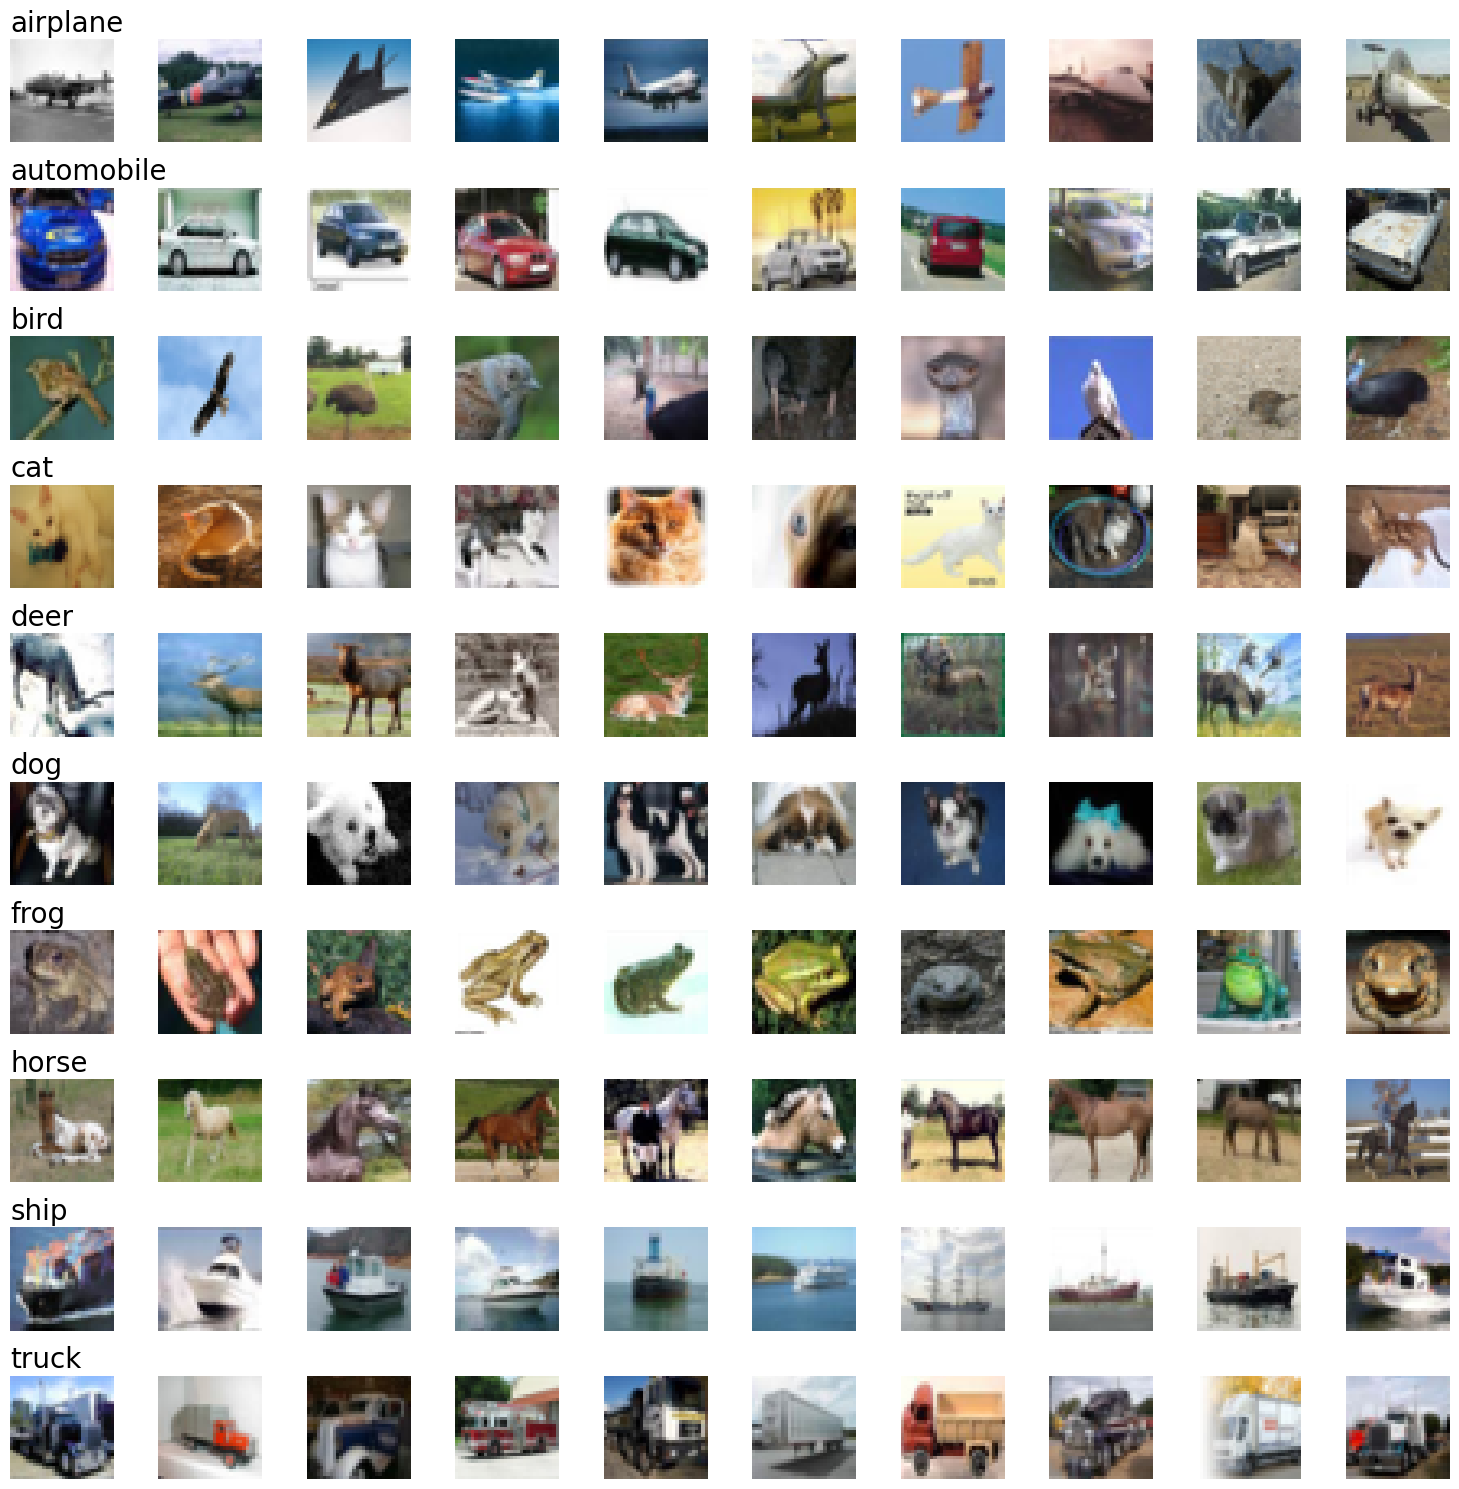

In [7]:
# Number of samples to display per class
num_samples = 10

# Create a figure
fig, axes = plt.subplots(len(LABEL_NAMES), num_samples, figsize=(15, 15))

# Iterate over each class
for class_idx, class_name in enumerate(LABEL_NAMES):
    # Find the indices of images belonging to the current class
    class_indices = np.where(y_train.flatten() == class_idx)[0]

    # Randomly select `num_samples` images from the class
    selected_indices = np.random.choice(class_indices, num_samples, replace=False)

    # Plot the images
    for i, img_idx in enumerate(selected_indices):
        ax = axes[class_idx, i]
        ax.imshow(x_train[img_idx])
        ax.axis("off")
        if i == 0:  # Add class name only on the first image
            ax.set_title(class_name, fontsize=20, loc="left")

# Adjust layout and display
plt.tight_layout()
plt.show()

## PARTITION TRAINING INTO VALIDATION
Dataset comes with
- training set (50,000)
- test set (10,000)

Now split training set into:
- training set
- validation set

Rationale:
- *** Research here as to correct size.
- 10%, 20%?????

Result:
- training set (40,000)
- validation set (10,000)
- test set (10,000)

In [8]:
# Split the training data into training and validation sets
x_train, x_validate, y_train, y_validate = train_test_split(
    x_train, y_train, test_size=0.2, random_state=0)

# Check the new shapes
print(f"New training data shape: {x_train.shape}")
print(f"Validation data shape: {x_validate.shape}")
print(f"New training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_validate.shape}")

New training data shape: (40000, 32, 32, 3)
Validation data shape: (10000, 32, 32, 3)
New training labels shape: (40000, 1)
Validation labels shape: (10000, 1)


## PRE-PROCESSING

- Preprocess after partitioning to not influence the test set.
- Normalise
- One-hot encode class labels

### Normalise

- RGB channel pixel value intensities range from 0 to 255
- 0 = black
- 255 (original) or 1 (normalised) = full intensity
- Red (R) channel = 0
- Green (G) channel = 1
- Blue (B) channel = 2
- Normalising helps Neural Network

#### Understand the data

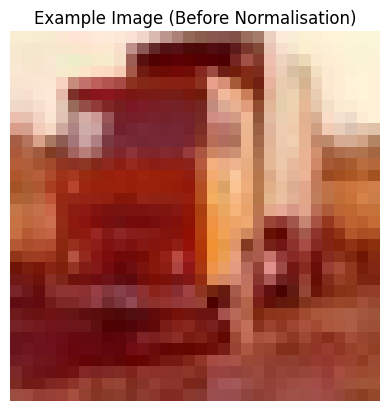

Pixel values (partial):
[[248 248 247 246 252]
 [247 245 245 246 248]
 [248 245 246 248 241]
 [250 248 247 248 246]
 [248 248 251 251 245]]


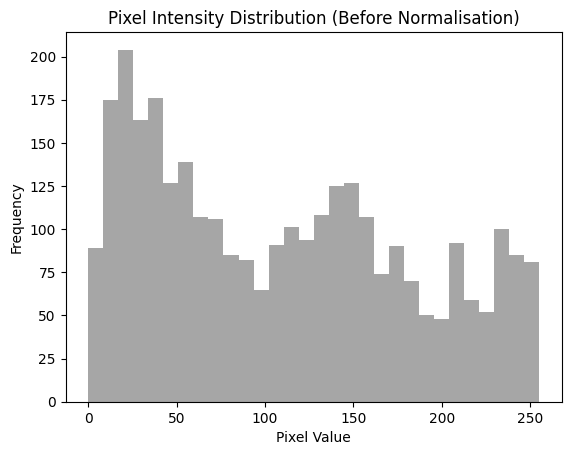

In [9]:
# Choose an example image from the training set
example_image = x_train[100]

# Display the image
plt.imshow(example_image)
plt.title("Example Image (Before Normalisation)")
plt.axis("off")
plt.show()

# Print pixel values for first five rows and columns of image
print("Pixel values (partial):")
print(example_image[:5, :5, 0])  # First channel (R)

# Visualise pixel intensity distribution
plt.hist(example_image.flatten(), bins=30, color='grey', alpha=0.7)
plt.title("Pixel Intensity Distribution (Before Normalisation)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

In [10]:
# Display the original range of pixel values
print("Original pixel range (train):", np.min(x_train), "to", np.max(x_train))
print("Original pixel range (validate):", np.min(x_validate), "to", np.max(x_validate))
print("Original pixel range (test):", np.min(x_test), "to", np.max(x_test))

Original pixel range (train): 0 to 255
Original pixel range (validate): 0 to 255
Original pixel range (test): 0 to 255


#### Normalise RGB from [0, 255] to [0, 1]

In [11]:
# Normalize the image data to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_validate = x_validate.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Display the new range of pixel values
print("Normalized pixel range (train):", np.min(x_train), "to", np.max(x_train))
print("Normalized pixel range (validate):", np.min(x_validate), "to", np.max(x_validate))
print("Normalized pixel range (test):", np.min(x_test), "to", np.max(x_test))

Normalized pixel range (train): 0.0 to 1.0
Normalized pixel range (validate): 0.0 to 1.0
Normalized pixel range (test): 0.0 to 1.0


#### Understand the normalisation change

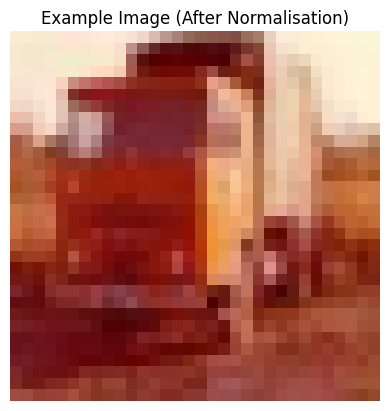

Pixel values (partial):
[[0.972549   0.972549   0.96862745 0.9647059  0.9882353 ]
 [0.96862745 0.9607843  0.9607843  0.9647059  0.972549  ]
 [0.972549   0.9607843  0.9647059  0.972549   0.94509804]
 [0.98039216 0.972549   0.96862745 0.972549   0.9647059 ]
 [0.972549   0.972549   0.9843137  0.9843137  0.9607843 ]]


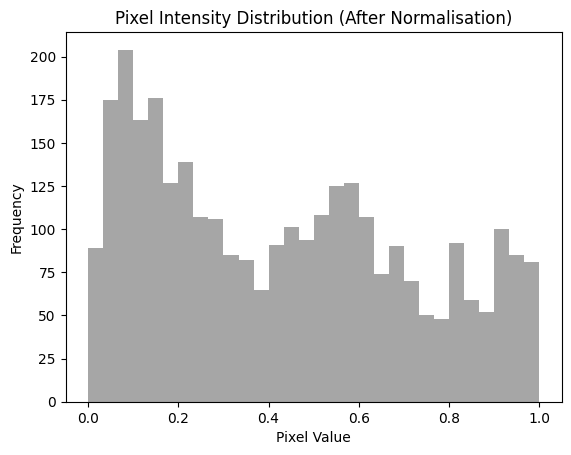

In [12]:
# Choose an example image from the training set
normalised_example_image = x_train[100]

# Display the image
plt.imshow(example_image)
plt.title("Example Image (After Normalisation)")
plt.axis("off")
plt.show()

# Print pixel values for the first few rows of the image
print("Pixel values (partial):")
print(normalised_example_image[:5, :5, 0])  # First channel (R)

# Visualise pixel intensity distribution
plt.hist(normalised_example_image.flatten(), bins=30, color='grey', alpha=0.7)
plt.title("Pixel Intensity Distribution (After Normalisation)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

### One-hot encode
- [9] is truck
- [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] is one-hot encoding of [9] and still means truck

In [13]:
# Show an example label before one-hot encoding
print("Label before one-hot encoding:", y_train[100])

# Convert class labels to one-hot encoded format
y_train = to_categorical(y_train, num_classes=10)
y_validate = to_categorical(y_validate, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print("Label after one-hot encoding:", y_train[100])

Label before one-hot encoding: [9]
Label after one-hot encoding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


### Shape

- Data is still the same shape
- Labels are now 10, not 1

In [14]:
# Check the shapes of the preprocessed data
print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_validate.shape}")
print(f"Testing data shape: {x_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_validate.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (40000, 32, 32, 3)
Validation data shape: (10000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)
Training labels shape: (40000, 10)
Validation labels shape: (10000, 10)
Testing labels shape: (10000, 10)


# MODELS BELOW MEANT TO BE RUN INDIVIDUALLY IN A FRESH SESSION

- Running sequentially will not work
- This was to try out separate models for comparison.

## MODEL 1 (BASELINE)

Adjustments:
- None, baseline.

Architecture
- Number layers: 3
- Convolutional filters (kernels): 32, 64, 128
- Convolutional filter (kernel) size: 3x3
- Pool size: 2x2
- Dropout rate: 50%
- Dense: 128, 64
- Activation function: ReLU

Compile
- Optimiser: Adam
- Learning rate: .001
- Loss function: categorical crossentropy
- Metric: accuracy

Training settings:
- Epochs: 20
- Batch size: 64

Best Performance:
- Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7424 - loss: 0.7327
- Epoch 11: val_loss improved from 0.89218 to 0.88261, saving model to model_1_best.keras
-625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 103ms/step - accuracy: 0.7424 - loss: 0.7327 - val_accuracy: 0.7001 - val_loss: 0.8826

Visualisation: Model Accuracy
- Epoch 10-11 Validation plateaus

Visualisation: Model Loss
- Epoch 10-11 Validation increases (bad)

Summary
- Stops generalising at epoch 10-11
- Further epochs not useful
- Overfitting

### Neural Network Architecture

In [ ]:
# Initialize the model
model_1 = Sequential()

# Add convolutional and pooling layers
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))

# Flatten the feature maps into a 1D vector
model_1.add(Flatten())

# Add fully connected (dense) layers
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))  # Randomly drop 50% neurons to prevent overfitting
model_1.add(Dense(64, activation='relu'))

# Classifier: Output layer with 10 classes
model_1.add(Dense(10, activation='softmax'))

# Print the model summary
model_1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 364,426 (1.39 MB)

 Trainable params: 364,426 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model


In [ ]:
# Compile the model
model_1.compile(
    optimizer=Adam(learning_rate=0.001), # Adaptive learning rate optimizer
    loss='categorical_crossentropy',     # Loss function for multi-class classification
    metrics=['accuracy']                 # Metric to track during training
)

### Keep Best Model

In [ ]:
checkpoint_1 = ModelCheckpoint(
    filepath='model_1_best.keras',  # Save model 1 separately
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

### Train and Validate


In [ ]:
# Train the model
history_1 = model_1.fit(
    x_train, y_train,                         # Training data and labels
    validation_data=(x_validate, y_validate), # Validation data and labels
    epochs=20,                                # Number of epochs (you can adjust this)
    batch_size=64,                            # Number of samples per batch
    callbacks=[checkpoint_1],                 # Include ModelCheckpoint
    verbose=1                                 # Print training progress
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.2473 - loss: 1.9691
Epoch 1: val_loss improved from inf to 1.51975, saving model to model_1_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 103ms/step - accuracy: 0.2474 - loss: 1.9688 - val_accuracy: 0.4503 - val_loss: 1.5198
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4663 - loss: 1.4640
Epoch 2: val_loss improved from 1.51975 to 1.22594, saving model to model_1_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 100ms/step - accuracy: 0.4664 - loss: 1.4639 - val_accuracy: 0.5599 - val_loss: 1.2259
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5479 - loss: 1.2754
Epoch 3: val_loss improved from 1.22594 to 1.07604, saving model to model_1_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 97ms/step - accuracy: 0.5479 - loss: 1.2754 - val_accuracy: 0.6133 - val_loss: 1.0760
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5976 - loss: 1.1384
Epoch 4: val_loss improved from 1.07

### Visualise

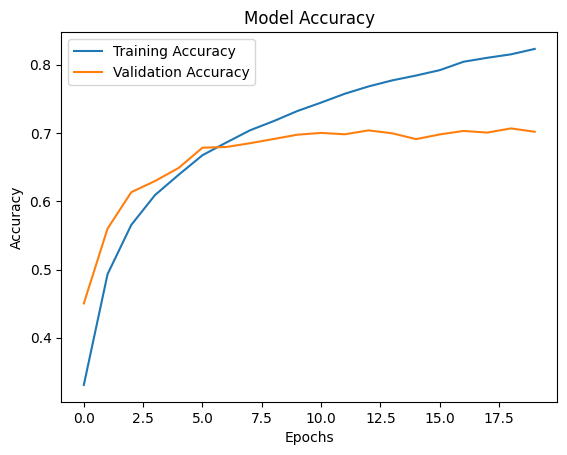

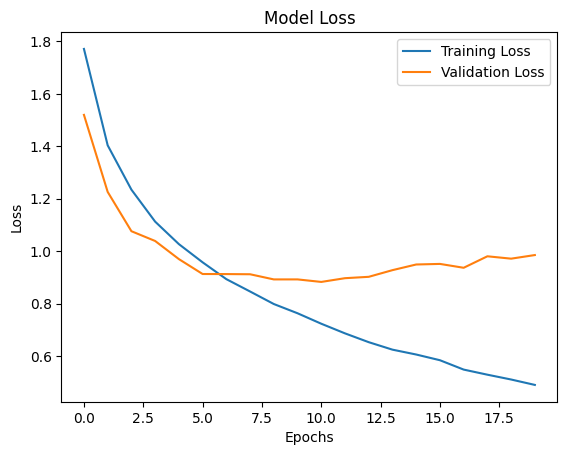

In [ ]:
# Plot training and validation accuracy
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## MODEL 2 (DATA AUGMENTAION & EARLY STOPPING => IMPROVES OVERFITTING)

Adjustments to avoid overfitting:
- Data augmentation to artificially increase diversity of training data
- Early stopping when loss stops improving

Architecture (unchanged)
- Number layers: 3
- Convolutional filters (kernels): 32, 64, 128
- Convolutional filter (kernel) size: 3x3
- Pool size: 2x2
- Dropout rate: 50%
- Dense: 128, 64
- Activation function: ReLU

Compile (unchanged)
- Optimiser: Adam
- Learning rate: .001
- Loss function: categorical crossentropy
- Metric: accuracy

Training settings
- Epochs: 20 (with early stopping)
- Batch size: 64

Best Performance:
- Epoch 18/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6868 - loss: 0.9076
- Epoch 18: val_loss improved from 0.79698 to 0.78207, saving model to model_2_best.keras
- 625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 142ms/step - accuracy: 0.6868 - loss: 0.9076 - val_accuracy: 0.7258 - val_loss: 0.7821

Visualisation: Model Accuracy
- Training lower due to augmentation complexity (expected)
- Validation consistently higher (good)

Visualisation: Model Loss
- Training higher due to augmentation complexity (expected)
- Validation consistently lower (good)

Summary
- No divergence between train and validate
- Overfitting mitigated
- Model learned features
- Improved generalisation


### Neural Network Architecture

In [ ]:
# Initialize the model
model_2 = Sequential()

# Add convolutional and pooling layers
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))

# Flatten the feature maps into a 1D vector
model_2.add(Flatten())

# Add fully connected (dense) layers
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5))  # Randomly drop 50% neurons to prevent overfitting
model_2.add(Dense(64, activation='relu'))

# Classifier: Output layer with 10 classes
model_2.add(Dense(10, activation='softmax'))

# Print the model summary
model_2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 364,426 (1.39 MB)

 Trainable params: 364,426 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model

In [ ]:
# Compile the model
model_2.compile(
    optimizer=Adam(learning_rate=0.001), # Adaptive learning rate optimizer
    loss='categorical_crossentropy',     # Loss function for multi-class classification
    metrics=['accuracy']                 # Metric to track during training
)

### Data Augmentation

In [ ]:
# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,       # Random rotation up to 15 degrees
    width_shift_range=0.1,   # Random horizontal shifts (10% of image width)
    height_shift_range=0.1,  # Random vertical shifts (10% of image height)
    horizontal_flip=True     # Random horizontal flips
)

# Fit the augmentation generator to the training data (x_train is untouched)
datagen.fit(x_train, seed=42)

### Early Stopping

In [ ]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=3,               # Stop after 3 epochs of no improvement
    restore_best_weights=True # Revert to the best weights
)

### Keep Best Model

In [ ]:
checkpoint_2 = ModelCheckpoint(
    filepath='model_2_best.keras',  # Save model 2 separately
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

### Train and Validate

In [ ]:
# Train the model with data augmentation and early stopping
history_2 = model_2.fit(
    datagen.flow(x_train, y_train, batch_size=64), # Use augmented data
    validation_data=(x_validate, y_validate),      # Validation data remains unaugmented
    epochs=20,
    callbacks=[checkpoint_2, early_stopping],      # Add early stopping
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.2214 - loss: 2.0353
Epoch 1: val_loss improved from inf to 1.44138, saving model to model_2_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 158ms/step - accuracy: 0.2215 - loss: 2.0350 - val_accuracy: 0.4687 - val_loss: 1.4414
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.4244 - loss: 1.5586
Epoch 2: val_loss improved from 1.44138 to 1.38874, saving model to model_2_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 91s 144ms/step - accuracy: 0.4244 - loss: 1.5585 - val_accuracy: 0.4888 - val_loss: 1.3887
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4866 - loss: 1.4169
Epoch 3: val_loss improved from 1.38874 to 1.16506, saving model to model_2_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 144ms/step - accuracy: 0.4866 - loss: 1.4169 - val_accuracy: 0.5834 - val_loss: 1.1651
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5264 - loss: 1.3136
Epoch 4: val_loss improved from 1.16506 

### Visualise

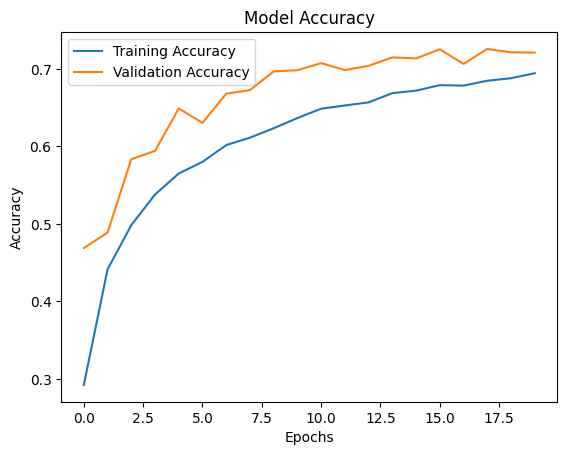

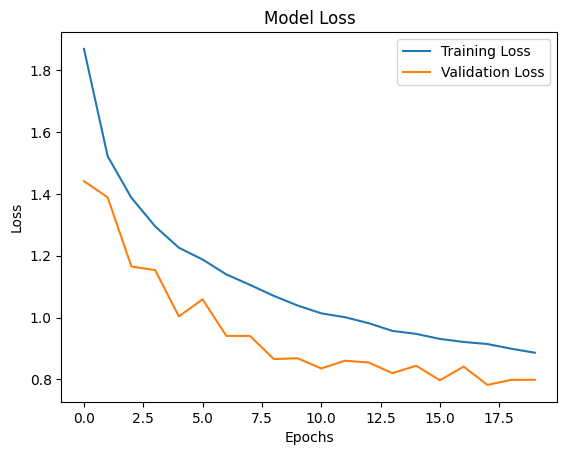

In [ ]:
# Plot training and validation accuracy
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## MODEL 3 (L2 REGULATION = .01 => UNDERFITS)

Adjustment to further improve generalisation and robustness:
- L2 Regularisation modifies loss function to prevent model from over-relying on certain features or weight configurations

Architecture
- Number layers: 3
- Convolutional filters (kernels): 32, 64, 128
- Convolutional filter (kernel) size: 3x3
- Pool size: 2x2
- Dropout rate: 50%
- Dense: 128, 64
- Activation function: ReLU
- L2 regularisation: .01 (NEW)

Compile (unchanged)
- Optimiser: Adam
- Learning rate: .001
- Loss function: categorical crossentropy
- Metric: accuracy

Training settings (unchanged)
- Epochs: 20 (with early stopping)
- Batch size: 64

Best Performance:
- Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6064 - loss: 1.2899
- Epoch 16: val_loss improved from 1.15219 to 1.09505, saving model to model_3_best.keras
- 625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 125ms/step - accuracy: 0.6064 - loss: 1.2899 - val_accuracy: 0.6691 - val_loss: 1.0950

Visualisation: Model Accuracy
- Training lower (bad)
- Validation lower and erratic (bad)

Visualisation: Model Loss
- Training higher (bad)
- Validation higher and erratic (bad)

Summary
- Underfitting due to too high L2


### Neural Network Architecture (L2 = .01)

In [ ]:
# Initialize the model
model_3 = Sequential()

# Add convolutional and pooling layers
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))

# Flatten the feature maps into a 1D vector
model_3.add(Flatten())

# Fully connected (dense) layers with L2 regularisation
model_3.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01))) # Add L2
model_3.add(Dropout(0.5))  # Randomly drop 50% neurons to prevent overfitting
model_3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01))) # Add L2

# Classifier: Output layer with 10 classes
model_3.add(Dense(10, activation='softmax'))

# Print the model summary
model_3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 364,426 (1.39 MB)

 Trainable params: 364,426 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model

In [ ]:
# Compile the model
model_3.compile(
    optimizer=Adam(learning_rate=0.001), # Adaptive learning rate optimizer
    loss='categorical_crossentropy',     # Loss function for multi-class classification
    metrics=['accuracy']                 # Metric to track during training
)

### Data Augmentation

In [ ]:
# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,       # Random rotation up to 15 degrees
    width_shift_range=0.1,   # Random horizontal shifts (10% of image width)
    height_shift_range=0.1,  # Random vertical shifts (10% of image height)
    horizontal_flip=True     # Random horizontal flips
)

# Fit the augmentation generator to the training data (x_train is untouched)
datagen.fit(x_train, seed=42) # Seed for reproducability

### Early Stopping

In [ ]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=3,               # Stop after 3 epochs of no improvement
    restore_best_weights=True # Revert to the best weights
)

### Keep Best Model

In [ ]:
checkpoint_3 = ModelCheckpoint(
    filepath='model_3_best.keras',  # Save model 3 separately
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

### Train and Validate

In [ ]:
# Train the model with data augmentation and early stopping
history_3 = model_3.fit(
    datagen.flow(x_train, y_train, batch_size=64), # Use augmented data
    validation_data=(x_validate, y_validate),      # Validation data remains unaugmented
    epochs=20,
    callbacks=[checkpoint_3, early_stopping],      # Save best, stop early
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2264 - loss: 2.6273
Epoch 1: val_loss improved from inf to 1.68862, saving model to model_3_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 127ms/step - accuracy: 0.2265 - loss: 2.6265 - val_accuracy: 0.4104 - val_loss: 1.6886
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3790 - loss: 1.7584
Epoch 2: val_loss improved from 1.68862 to 1.58259, saving model to model_3_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 127ms/step - accuracy: 0.3791 - loss: 1.7584 - val_accuracy: 0.4628 - val_loss: 1.5826
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4332 - loss: 1.6530
Epoch 3: val_loss improved from 1.58259 to 1.54211, saving model to model_3_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 127ms/step - accuracy: 0.4332 - loss: 1.6530 - val_accuracy: 0.4910 - val_loss: 1.5421
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4679 - loss: 1.5826
Epoch 4: val_loss did not improve from 1.5

### Visualise

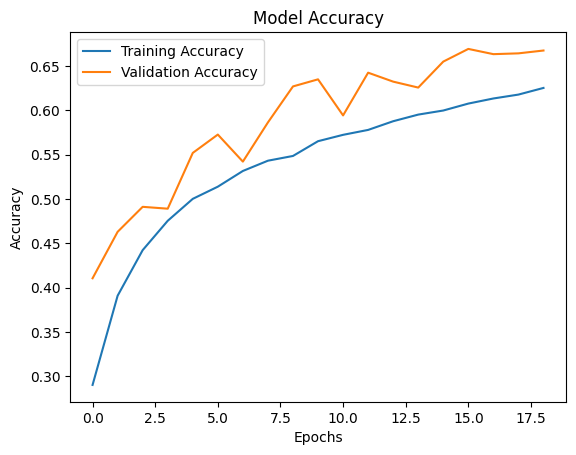

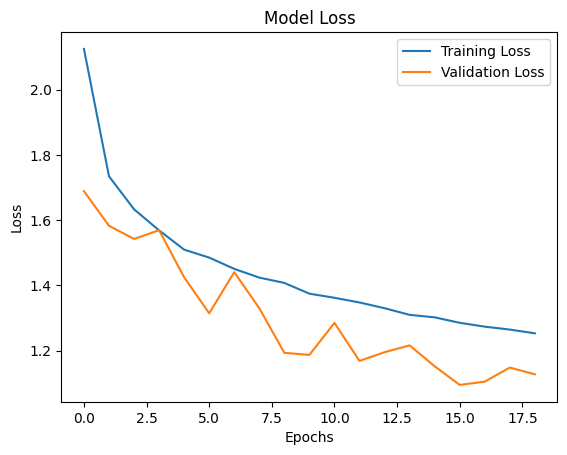

In [ ]:
# Plot training and validation accuracy
plt.plot(history_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_3.history['loss'], label='Training Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## MODEL 4 (L2 REGULATION = .001)

Adjustment to L2 to stop underfitting:
- L2 reduced from .01 to .001

Architecture
- Number layers: 3
- Convolutional filters (kernels): 32, 64, 128
- Convolutional filter (kernel) size: 3x3
- Pool size: 2x2
- Dropout rate: 50%
- Dense: 128, 64
- Activation function: ReLU
- L2 regularisation: .001 (CHANGE)

Compile (unchanged)
- Optimiser: Adam
- Learning rate: .001
- Loss function: categorical crossentropy
- Metric: accuracy

Training settings (unchanged)
- Epochs: 20 (with early stopping)
- Batch size: 64

Performance:
- Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6664 - loss: 1.0656
- Epoch 16: val_loss improved from 0.89016 to 0.87893, saving model to model_4_best.keras
- 625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.6664 - loss: 1.0656 - val_accuracy: 0.7310 - val_loss: 0.8789

Summary
- Still underfitting. L2 not useful



### Neural Network Architecture (L2 = .001)

In [ ]:
# Initialize the model
model_4 = Sequential()

# Add convolutional and pooling layers
model_4.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))

# Flatten the feature maps into a 1D vector
model_4.add(Flatten())

# Fully connected (dense) layers with L2 regularisation
model_4.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001))) # Lower L2
model_4.add(Dropout(0.5))  # Randomly drop 50% neurons to prevent overfitting
model_4.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001))) # Lower L2

# Classifier: Output layer with 10 classes
model_4.add(Dense(10, activation='softmax'))

# Print the model summary
model_4.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 364,426 (1.39 MB)

 Trainable params: 364,426 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model

In [ ]:
# Compile the model
model_4.compile(
    optimizer=Adam(learning_rate=0.001), # Adaptive learning rate optimizer
    loss='categorical_crossentropy',     # Loss function for multi-class classification
    metrics=['accuracy']                 # Metric to track during training
)

### Data Augmentation

In [ ]:
# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,       # Random rotation up to 15 degrees
    width_shift_range=0.1,   # Random horizontal shifts (10% of image width)
    height_shift_range=0.1,  # Random vertical shifts (10% of image height)
    horizontal_flip=True     # Random horizontal flips
)

# Fit the augmentation generator to the training data (x_train is untouched)
datagen.fit(x_train, seed=42) # Seed for reproducability

### Early Stopping

In [ ]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=3,               # Stop after 3 epochs of no improvement
    restore_best_weights=True # Revert to the best weights
)

### Keep Best Model

In [ ]:
checkpoint_4 = ModelCheckpoint(
    filepath='model_4_best.keras',  # Save model 3 separately
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

### Train and Validate

In [ ]:
# Train the model with data augmentation and early stopping
history_4 = model_4.fit(
    datagen.flow(x_train, y_train, batch_size=64), # Use augmented data
    validation_data=(x_validate, y_validate),      # Validation data remains unaugmented
    epochs=20,
    callbacks=[checkpoint_4, early_stopping],      # Save best, early stopping
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.2357 - loss: 2.1250
Epoch 1: val_loss improved from inf to 1.57462, saving model to model_4_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 159ms/step - accuracy: 0.2358 - loss: 2.1247 - val_accuracy: 0.4398 - val_loss: 1.5746
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.4189 - loss: 1.6439
Epoch 2: val_loss improved from 1.57462 to 1.47398, saving model to model_4_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 130s 140ms/step - accuracy: 0.4189 - loss: 1.6438 - val_accuracy: 0.5000 - val_loss: 1.4740
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4789 - loss: 1.5125
Epoch 3: val_loss improved from 1.47398 to 1.32102, saving model to model_4_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 137s 132ms/step - accuracy: 0.4789 - loss: 1.5124 - val_accuracy: 0.5504 - val_loss: 1.3210
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5282 - loss: 1.4099
Epoch 4: val_loss improved from 1.32102

### Visualise

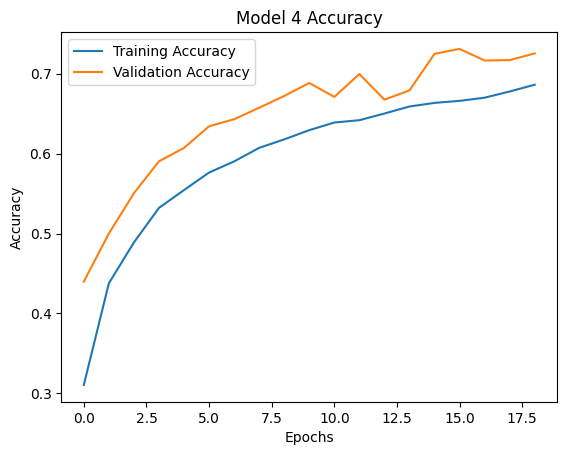

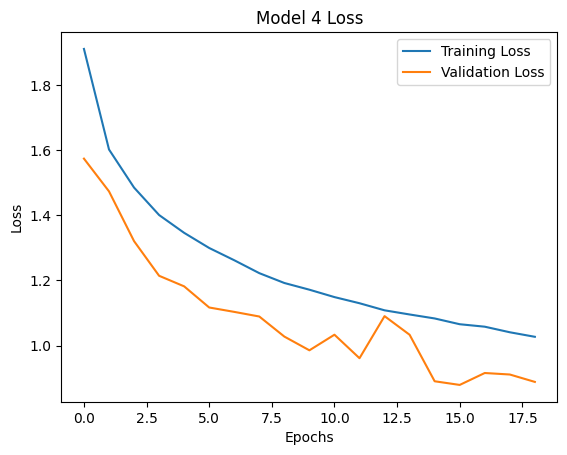

In [ ]:
# Plot training and validation accuracy
plt.plot(history_4.history['accuracy'], label='Training Accuracy')
plt.plot(history_4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 4 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_4.history['loss'], label='Training Loss')
plt.plot(history_4.history['val_loss'], label='Validation Loss')
plt.title('Model 4 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## MODEL 5

Adjustments:
- Removed L2
- Changed architecture to modified AlexNet (Zhang, 2021)
- 4 convolution layers with 3 pooling

Architecture
- Number layers: 4
- Convolutional filters (kernels): 32, 64, 128, 256
- Convolutional filter (kernel) size: 3x3
- Pool size: 2x2
- Dropout rate: 50%
- Dense: 128, 64
- Activation function: ReLU

Compile (unchanged)
- Optimiser: Adam
- Learning rate: .001
- Loss function: categorical crossentropy
- Metric: accuracy

Training settings
- Epochs: 30 (with early stopping)
- Batch size: 64

Performance:
- Epoch 19/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7083 - loss: 0.8453
- Epoch 19: val_loss improved from 0.79894 to 0.76910, saving model to model_5_best.keras
- 625/625 ━━━━━━━━━━━━━━━━━━━━ 111s 177ms/step - accuracy: 0.7083 - loss: 0.8453 - val_accuracy: 0.7322 - val_loss: 0.7691

Visualisation: Model Accuracy
- Training lower due to augmentation complexity (expected)
- Validation consistently higher (good)

Visualisation: Model Loss
- Training higher due to augmentation complexity (expected)
- Validation consistently lower (good)

Summary
- Improved



### Neural Network Architecture (Modified AlexNet)

- (Zhang, 2021) suggests that 5 convolutional layers with 3 pooling layers, based on AlexNet improve accuracy for CIFAR-10
- Started with just adding one at 256

In [15]:
# Initialize the model
model_5 = Sequential()

# Add convolutional and pooling layers
model_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

model_5.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

model_5.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model_5.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps into a 1D vector
model_5.add(Flatten())

# Add fully connected (dense) layers
model_5.add(Dense(128, activation='relu'))
model_5.add(Dropout(0.5))  # Randomly drop 50% neurons to prevent overfitting
model_5.add(Dense(64, activation='relu'))

# Classifier: Output layer with 10 classes
model_5.add(Dense(10, activation='softmax'))

# Print the model summary
model_5.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 430,218 (1.64 MB)

 Trainable params: 430,218 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model

In [16]:
# Compile the model
model_5.compile(
    optimizer=Adam(learning_rate=0.001), # Adaptive learning rate optimizer
    loss='categorical_crossentropy',     # Loss function for multi-class classification
    metrics=['accuracy']                 # Metric to track during training
)

### Data Augmentation

In [17]:
# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,       # Random rotation up to 15 degrees
    width_shift_range=0.1,   # Random horizontal shifts (10% of image width)
    height_shift_range=0.1,  # Random vertical shifts (10% of image height)
    horizontal_flip=True     # Random horizontal flips
)

# Fit the augmentation generator to the training data (x_train is untouched)
datagen.fit(x_train, seed=42) # Seed for reproducability

### Early Stopping

In [18]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=3,               # Stop after 3 epochs of no improvement
    restore_best_weights=True # Revert to the best weights
)

### Keep Best Model

In [19]:
checkpoint_5 = ModelCheckpoint(
    filepath='model_5_best.keras',  # Save model 3 separately
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

### Train and Validate

In [20]:
# Train the model with data augmentation and early stopping
history_5 = model_5.fit(
    datagen.flow(x_train, y_train, batch_size=64), # Use augmented data
    validation_data=(x_validate, y_validate),      # Validation data remains unaugmented
    epochs=30,
    callbacks=[checkpoint_5, early_stopping],      # Apply early stopping
    verbose=1
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.2053 - loss: 2.0586
Epoch 1: val_loss improved from inf to 1.50784, saving model to model_5_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 117s 177ms/step - accuracy: 0.2054 - loss: 2.0583 - val_accuracy: 0.4457 - val_loss: 1.5078
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.4233 - loss: 1.5622
Epoch 2: val_loss improved from 1.50784 to 1.34801, saving model to model_5_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 111s 178ms/step - accuracy: 0.4233 - loss: 1.5621 - val_accuracy: 0.5186 - val_loss: 1.3480
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.4933 - loss: 1.3988
Epoch 3: val_loss improved from 1.34801 to 1.16374, saving model to model_5_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 110s 175ms/step - accuracy: 0.4933 - loss: 1.3988 - val_accuracy: 0.5846 - val_loss: 1.1637
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5427 - loss: 1.2995
Epoch 4: val_loss did not improve from 

### Visualise

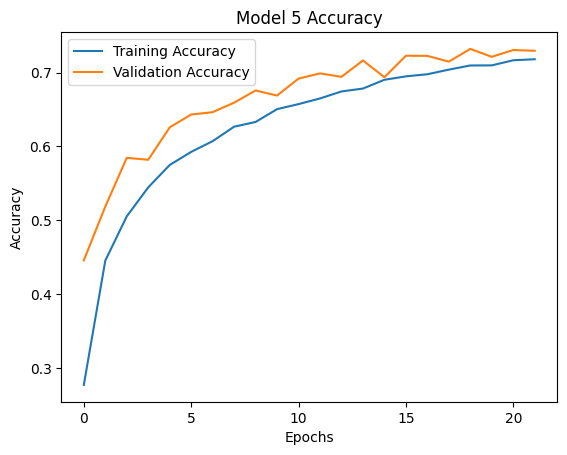

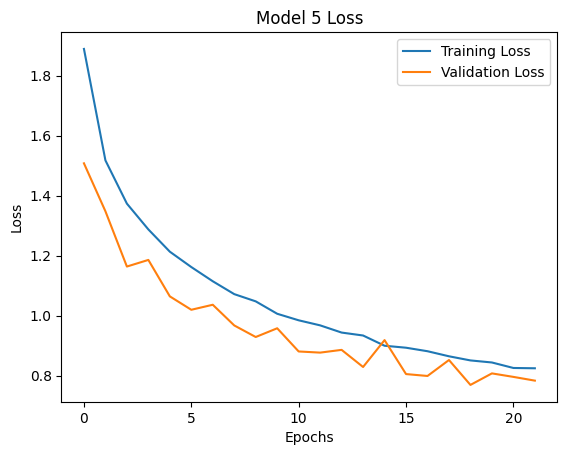

In [21]:
# Plot training and validation accuracy
plt.plot(history_5.history['accuracy'], label='Training Accuracy')
plt.plot(history_5.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_5.history['loss'], label='Training Loss')
plt.plot(history_5.history['val_loss'], label='Validation Loss')
plt.title('Model 5 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# TEST

## Load Model

- Ensure model loaded into Google Colab files

In [23]:
# Load the saved best model
model_best = load_model('model_5_best.keras')

# Confirm the model is loaded
model_best.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,290,656 (4.92 MB)

 Trainable params: 430,218 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 860,438 (3.28 MB)

## Evaluate on TEST set

In [24]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_best.evaluate(x_test, y_test, verbose=1)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7330 - loss: 0.7788
Test Loss: 0.7920995354652405
Test Accuracy: 0.7314000129699707


## Generate Predictions

In [25]:
# Get predictions for the test set
predictions = model_best.predict(x_test)

# Convert probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step


## Visualise Predictions

### Plot Example Predictions

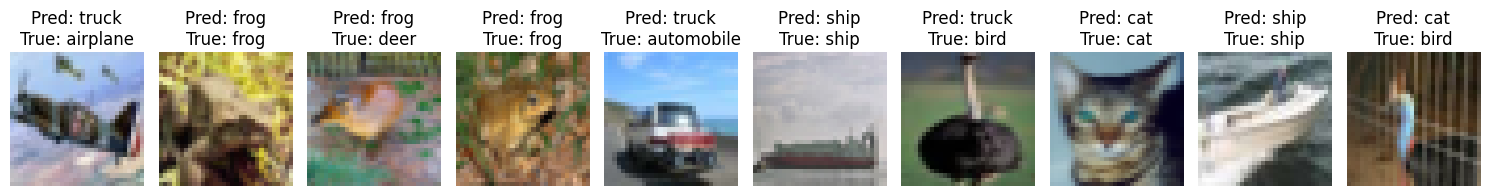

In [31]:
# Select random test images
num_images = 10
random_indices = np.random.choice(len(x_test), num_images, replace=False)
sample_images = x_test[random_indices]
sample_predictions = predicted_classes[random_indices]
sample_true_classes = true_classes[random_indices]

# Plot the images
plt.figure(figsize=(15, 5))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(sample_images[i])
    predicted_label = LABEL_NAMES[sample_predictions[i]]
    true_label = LABEL_NAMES[sample_true_classes[i]]
    plt.title(f"Pred: {predicted_label}\nTrue: {true_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Visualise Misclassified Examples

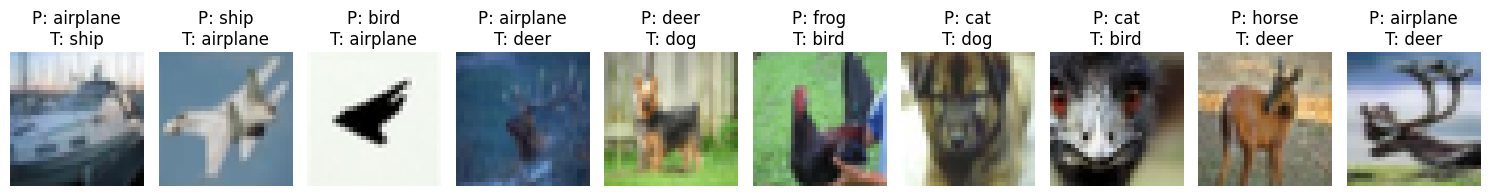

In [33]:
# Find misclassified indices
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# Plot some misclassified examples
plt.figure(figsize=(15, 5))
for i, idx in enumerate(misclassified_indices[:10]):  # Show up to 10 misclassified examples
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_test[idx])
    predicted_label = LABEL_NAMES[predicted_classes[idx]]
    true_label = LABEL_NAMES[true_classes[idx]]
    plt.title(f"P: {predicted_label}\nT: {true_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Function: Plot Image with Prediction

In [92]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)

    plt.xticks([])
    plt.yticks([])

    # Display the image
    plt.imshow(img, cmap=plt.cm.binary)

    # Get predicted label and its confidence
    predicted_label = np.argmax(predictions_array)
    confidence = 100 * np.max(predictions_array)

    # Determine label colour
    color = 'darkblue' if predicted_label == true_label else 'red'

    # Add the label and confidence to the image
    plt.xlabel(f"{LABEL_NAMES[predicted_label]}\n{confidence:.2f}%\n({LABEL_NAMES[true_label]})",
               color=color)

### Function: Plot Prediction Confidence Bar Chart

In [93]:
def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10), LABEL_NAMES, rotation=45, ha='right')  # Rotate and align labels
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])

    predicted_label = np.argmax(predictions_array)

    # Highlight predicted and true labels
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('darkblue')

### Visualise Prediction With Bar Chart

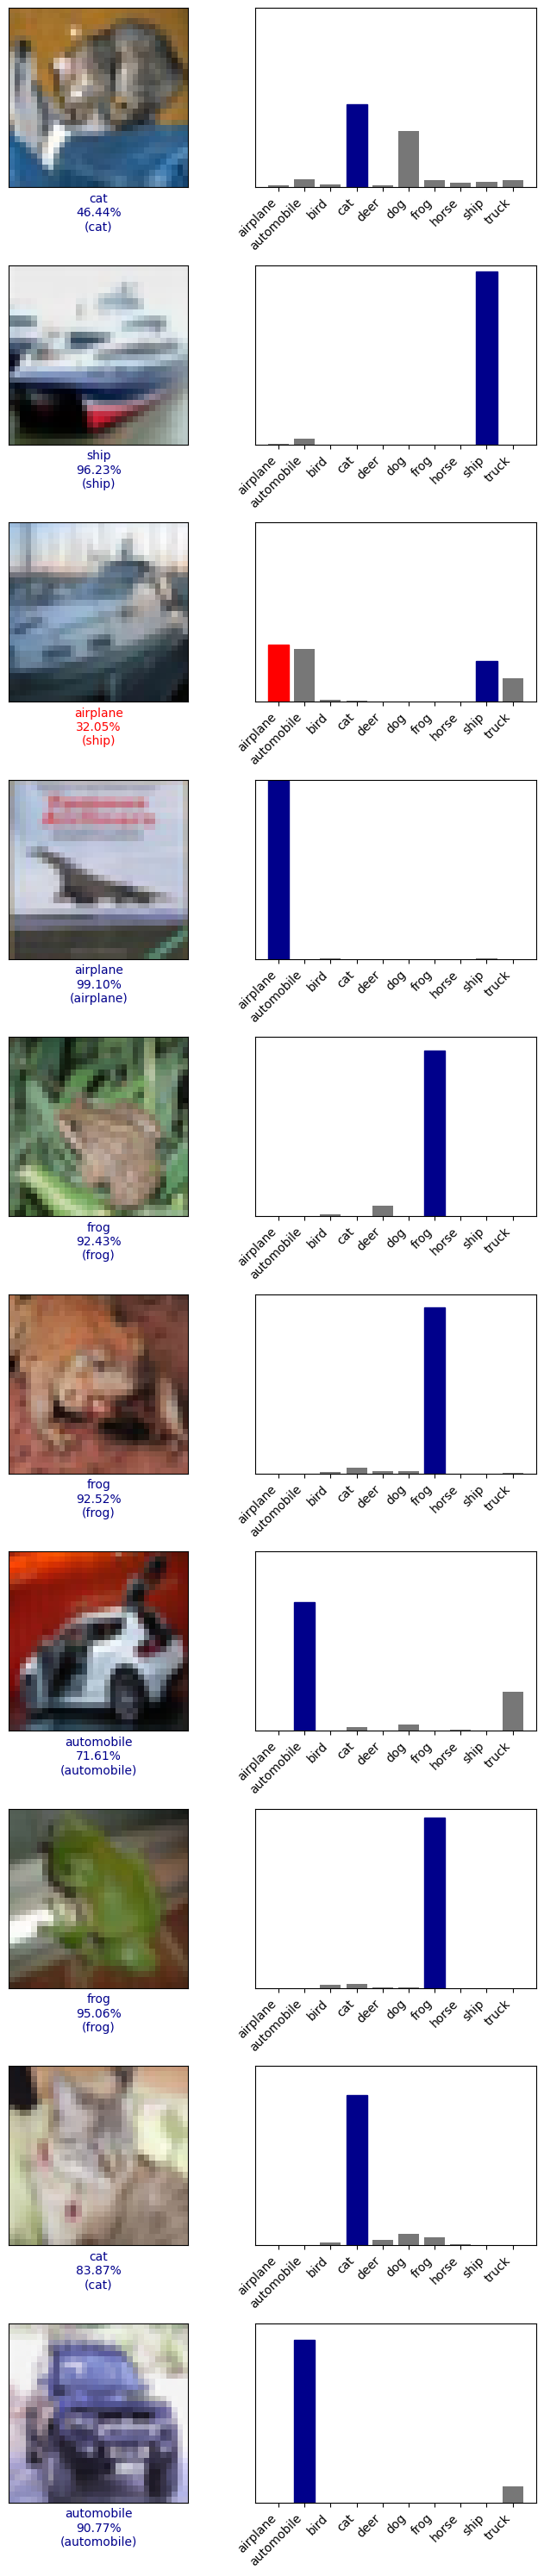

In [118]:
# Plot multiple images with predictions
num_rows, num_cols = 10, 1  # 10 rows, 1 image per row
num_images = num_rows * num_cols

plt.figure(figsize=(7 * num_cols, 3 * num_rows))  # Adjust figure size for better layout

for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], true_classes, x_test)

    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions[i], true_classes)

plt.tight_layout()  # Ensure plots don't overlap
plt.show()

### TRY ANY IMAGE 0-9999

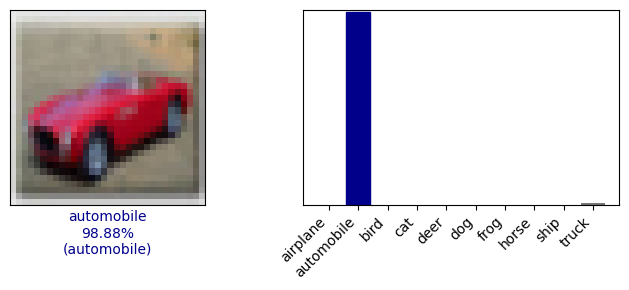

In [116]:
# Test a single image
i = 1234  # Index of the image to test

# Layout of subplots
plt.figure(figsize=(7, 3))

# Plot the image with prediction
plt.subplot(1, 2, 1)
plot_image(i, predictions[i], true_classes, x_test)

# Plot the confidence bar chart
plt.subplot(1, 2, 2)
plot_value_array(i, predictions[i], true_classes)

plt.tight_layout()
plt.show()

## Confusion Matrix

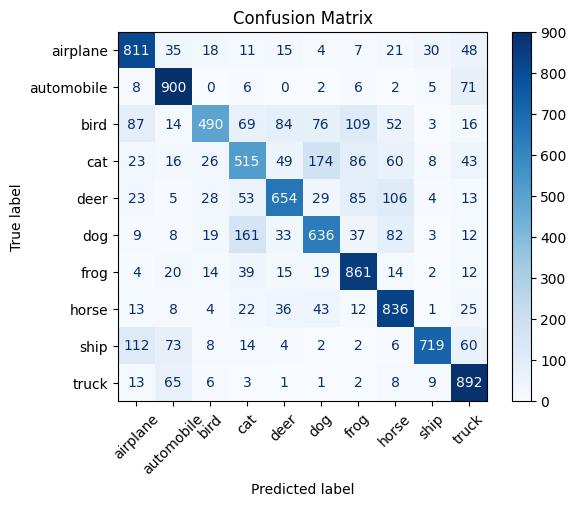

In [117]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualise the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=LABEL_NAMES)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()